In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

### Denormalize data to three dataframes
1. df_app_all: dataframe with details on both app and in_app content_id's
2. df_trn_denorm: dataframe with transactions, account, and device
3. df_wide: dataframe with all columns


#### Reason for df_app_all
transaction 'content_id' can either be the 'content_id' of the in_app item or the 'content_id' of the app

Solution: 
- create a table with union of both app and in_app
- To union app and in_app, I needed to define a type for app. As defined, type = 'the type of in-app content'. I added "download_only" as a new type for app. This behavior is when a user downloads the app, which is different from the "consumable" and "subscription" behaviors.


In [20]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [31]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'

In [32]:
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [27]:
# check if parent_app_content_id has no overlap to content_id
content_ids_in_app = df_in_app_denorm['content_id'].unique()
content_ids_app = df_app_denorm['content_id'].unique()

np.isin(content_ids_in_app, content_ids_app).sum()

0

In [28]:
content_ids_in_app.shape

(2376,)

In [29]:
content_ids_app.shape

(1000,)

parent_app_content_id and content_id is unique. I create a unique table for parent content id and union to in_app content_id table

In [35]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])

In [36]:
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


#### Create df_trn_denorm
Starting with transactions table, include information on device and account

About 2.7k transactions are missing account information

In [37]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

In [38]:
df_trn_denorm.isna().sum()

create_dt_transaction       0
content_id                  0
acct_id                     0
price                       0
device_id                   0
device_name                 0
create_dt_acct           2742
payment_type             2742
dtype: int64

### Create df_wide

In [39]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

In [45]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607509 entries, 0 to 3607508
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   create_dt_transaction  object 
 1   content_id             object 
 2   acct_id                object 
 3   price                  float64
 4   device_id              int64  
 5   device_name            object 
 6   create_dt_acct         object 
 7   payment_type           object 
 8   app_name               object 
 9   type                   object 
 10  category_name          object 
dtypes: float64(1), int64(1), object(9)
memory usage: 302.8+ MB


In [41]:
df_wide.isna().sum()

create_dt_transaction       0
content_id                  0
acct_id                     0
price                       0
device_id                   0
device_name                 0
create_dt_acct           2742
payment_type             2742
app_name                    0
type                        0
category_name               0
dtype: int64

In [42]:
# confirm that Free only has no price
df_wide[['price', 'payment_type']].groupby(by=['payment_type']).sum()

,price
payment_type,
Free only,0.00
PMOF,19037307.25


In [43]:
df_wide[['content_id', 'payment_type']].groupby(by=['payment_type']).count()

,content_id
payment_type,
Free only,1167271
PMOF,2437496


In [44]:
df_wide[['price', 'payment_type', 'type']].groupby(by=['payment_type', 'type']).sum()

price
payment_type type                      
Free only    download_only         0.00
PMOF         consumable     16797973.69
             download_only   1025178.66
             subscription    1214154.90

In [55]:
df_wide[['acct_id', 'payment_type', 'type']].groupby(by=['payment_type', 'type']).nunique()

acct_id
payment_type type                  
Free only    download_only    14993
PMOF         consumable       14982
             download_only    14982
             subscription     14982

In [56]:
df_wide[['acct_id', 'payment_type', 'type']].groupby(by=['payment_type']).nunique()

,acct_id,type
payment_type,,
Free only,14993,1
PMOF,14982,3


In [59]:
df_account[['acct_id', 'payment_type']].groupby(by=['payment_type']).nunique()

,acct_id
payment_type,
Free only,50000
PMOF,50000


### Investigate Subscription Accounts

In [46]:
acct_sub = df_wide[df_wide['type'] == 'subscription']['acct_id'].unique()

In [93]:
# label subscribers
df_wide['is_subscriber'] = np.where(df_wide['acct_id'].isin(acct_sub), "subscriber", "non-subscriber")

In [95]:
df_wide.groupby(by=['is_subscriber'], as_index=False).count()

,is_subscriber,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment_type2
0,non-subscriber,1168381,1168381,1168381,1168381,1168381,1168381,1167271,1167271,1168381,1168381,1168381,1167271
1,subscriber,2439128,2439128,2439128,2439128,2439128,2439128,2437496,2437496,2439128,2439128,2439128,2437496


In [47]:
df_wide[df_wide['acct_id'].isin(acct_sub)]['price'].count()

2439128

In [48]:
df_wide[df_wide['acct_id'].isin(acct_sub)]['price'].sum()

19049491.849999975

In [49]:
df_wide[df_wide['acct_id'].isin(acct_sub)]['price'].sum()/df_wide[df_wide['acct_id'].isin(acct_sub)]['price'].count()

7.809959891403803

In [50]:
df_wide[~df_wide['acct_id'].isin(acct_sub)]['price'].count()

1168381

In [51]:
df_wide[~df_wide['acct_id'].isin(acct_sub)]['price'].sum()

0.0

In [60]:
df_wide['payment_type2'] = df_wide['payment_type'] + ':' + df_wide['type']

In [54]:
df_wide[(df_wide['acct_id'].isin(acct_sub)) &
       (df_wide['type'] == 'download_only')]

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name
1460343,2016-09-03,51a852271344eefa,c93b5b4c590507c8,1.99,1,iPhone,10/9/07,PMOF,shrouds final,download_only,Entertainment
1460344,2016-08-14,11862d2d869936b2,37e26b546532db8e,7.99,1,iPhone,7/13/09,PMOF,medicament extremely,download_only,Utilities
1460345,2016-09-19,88690a5adabae694,b90e7de03c7dd694,0.99,1,iPhone,4/25/08,PMOF,fill port,download_only,Entertainment
1460346,2016-07-14,73d7bdb1778509e7,6db05fc4badfaa6d,5.99,1,iPhone,12/23/07,PMOF,parade deliverance,download_only,Utilities
1460347,2016-06-18,372e42bbaa3dc0e4,d3ec6ed049661453,0.99,1,iPhone,1/2/08,PMOF,lungs THEOLOGY,download_only,Games
...,...,...,...,...,...,...,...,...,...,...,...
3054702,2016-09-21,0ceab364ddb9372d,a269f5917d3da8e7,0.00,1,iPhone,7/12/10,PMOF,profoundest who,download_only,Games
3054703,2016-09-21,0ceab364ddb9372d,32c5446c52bbfd21,0.00,1,iPhone,9/5/10,PMOF,profoundest who,download_only,Games
3054704,2016-09-21,0ceab364ddb9372d,8834fcbfe20e1dfe,0.00,1,iPhone,1/1/12,PMOF,profoundest who,download_only,Games
3054705,2016-09-21,0ceab364ddb9372d,929a102def7c93a4,0.00,1,iPhone,9/24/09,PMOF,profoundest who,download_only,Games


In [88]:
df_wide2 = df_wide[['create_dt_transaction', 'payment_type2', 'price']]\
.groupby(by=['create_dt_transaction', 'payment_type2'], as_index=False).count()

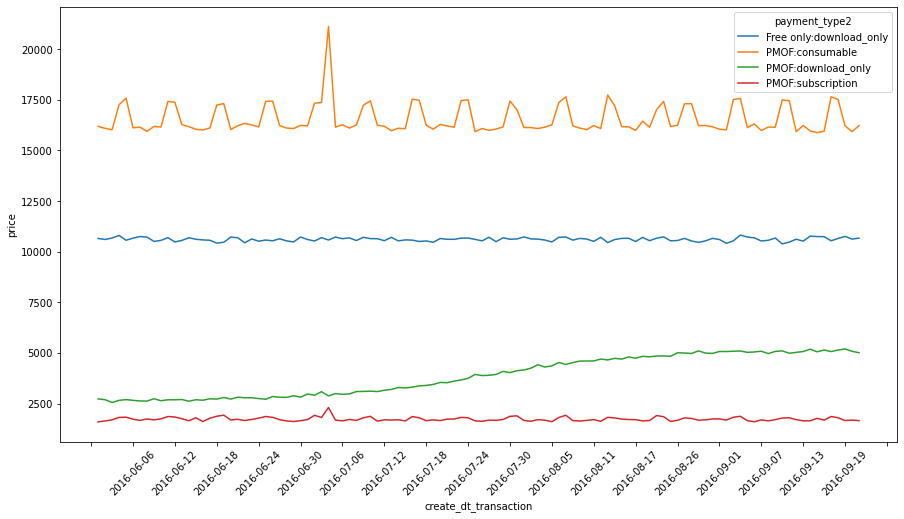

In [89]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', hue='payment_type2', 
             data=df_wide2)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gcf().autofmt_xdate()

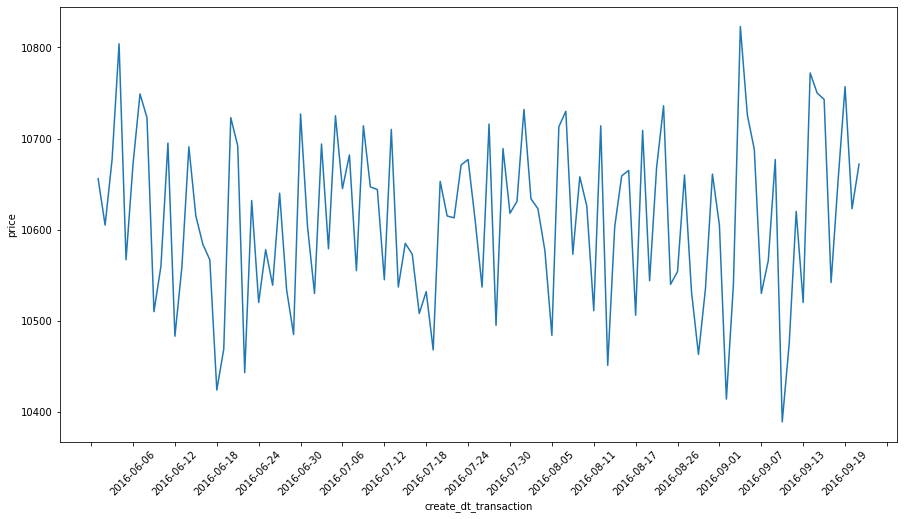

In [92]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='price', 
             data=df_wide2[(df_wide2['payment_type2'] == 'Free only:download_only')])

ax.xaxis.set_major_locator(mdates.DayLocator(interval=6))

In [85]:
df_wide2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 440 entries, ('2016-06-01', 'Free only:download_only') to ('2016-09-21', 'PMOF:subscription')
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   440 non-null    int64
dtypes: int64(1)
memory usage: 9.6+ KB


In [87]:
df_wide2 = df_wide[['create_dt_transaction', 'payment_type2', 'price']]\
.groupby(by=['create_dt_transaction', 'payment_type2']).count()
df_wide2

price
create_dt_transaction payment_type2                 
2016-06-01            Free only:download_only  10656
                      PMOF:consumable          16191
                      PMOF:download_only        2736
                      PMOF:subscription         1601
2016-06-02            Free only:download_only  10605
...                                              ...
2016-09-20            PMOF:subscription         1689
2016-09-21            Free only:download_only  10672
                      PMOF:consumable          16226
                      PMOF:download_only        5014
                      PMOF:subscription         1661

[440 rows x 1 columns]

### Look at difference in app category between subscribers and non-subscribers

In [96]:
df_wide.head()

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name,payment_type2,is_subscriber
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,iPhone,8/29/09,PMOF,events Bildad's,subscription,Utilities,PMOF:subscription,subscriber
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,iPad,5/28/11,PMOF,swell questionably,consumable,Utilities,PMOF:consumable,subscriber
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,iPad,11/15/09,PMOF,supperless--my Shipmates,consumable,Games,PMOF:consumable,subscriber
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,iPad,3/1/09,PMOF,unwritten hungry,consumable,Games,PMOF:consumable,subscriber
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,iPad,10/1/10,PMOF,Turning thanked,consumable,Entertainment,PMOF:consumable,subscriber


In [98]:
df_wide[['content_id','category_name', 'is_subscriber']]\
.groupby(by=['is_subscriber','category_name'], as_index=False).count()

,is_subscriber,category_name,content_id
0,non-subscriber,Entertainment,203699
1,non-subscriber,Games,406757
2,non-subscriber,Photos & Videos,276114
3,non-subscriber,Social Networking,51746
4,non-subscriber,Utilities,230065
5,subscriber,Entertainment,224569
6,subscriber,Games,1292941
7,subscriber,Photos & Videos,572003
8,subscriber,Social Networking,108798
9,subscriber,Utilities,240817


In [99]:
df_wide[['price','category_name', 'is_subscriber']]\
.groupby(by=['is_subscriber','category_name'], as_index=False).sum()

,is_subscriber,category_name,price
0,non-subscriber,Entertainment,0.00
1,non-subscriber,Games,0.00
2,non-subscriber,Photos & Videos,0.00
3,non-subscriber,Social Networking,0.00
4,non-subscriber,Utilities,0.00
5,subscriber,Entertainment,1397391.31
6,subscriber,Games,12267799.72
7,subscriber,Photos & Videos,3421675.97
8,subscriber,Social Networking,625992.02
9,subscriber,Utilities,1336632.83
